In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / 'sensitivity_v2' / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
df_imgs

,Condition,FOV,Path
0,100nM,C,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
1,10nM,E,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
2,25nM,D,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
3,5nM,F,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
4,Control,B,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...


# PLA quantification

In [6]:
import PLA

PPI_save_path =  data_dir / 'sensitivity_v2' / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [7]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
    print(markers)


['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']
['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']
['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']
['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']
['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']


In [8]:
df_imgs['FOV'] = df_imgs['FOV'].astype(str)

In [9]:
df_imgs

,Condition,FOV,Path
0,100nM,C,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
1,10nM,E,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
2,25nM,D,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
3,5nM,F,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...
4,Control,B,Y:\coskun-lab\Thomas\23_PLA_revision\data\sens...


In [10]:
RNAs = ['Sox2/Oct4','p-P90rsk/NF-Kb','Cyclin D1/CDK4','Bim/Tom20']

thresholds = [0.05, 0.02, 0.07, 0.07]
for row in df_imgs.iloc[[0,2]].itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path)
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        
    imgs_spots = []
    imgs_wths = []
    imgs_raws = []
    for i, RNA in enumerate(RNAs): 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=thresholds[i], min_radius=1.5)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
            imgs_raws.append(img)

    # Save PPI dict
    name = '_'.join(row[1:3])+'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)

Reading image Sox2/Oct4
Processing image Sox2/Oct4


KeyboardInterrupt: 

In [104]:
import napari

viewer = napari.view_image(np.stack(imgs_wths))
viewer.add_image(np.stack(imgs_raws))
viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

<Image layer 'Image [2]' at 0x2552d10d490>

# QC segmentation

In [49]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=small_size)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [50]:
# Read masks paths 
mask_dir = data_dir /  'sensitivity_v2' / 'imgs' / 'masks'
mask_filt_dir = data_dir /  'sensitivity_v2' / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [51]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

C:\Users\thu71\AppData\Roaming\Python\Python310\site-packages\skimage\_shared\utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


In [52]:
# import napari

# viewer = napari.view_labels(cell)
# viewer.add_labels(nuclei)

# Extract per cell PPI count

In [106]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [107]:
mask_filt_dir = data_dir /'sensitivity_v2'  / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / 'sensitivity_v2'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [110]:
for row in df_imgs.iloc[[0,2]].itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
    
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

# PPI quantification

In [6]:
# Read PPI 
PPI_save_path =  data_dir / 'sensitivity_v2' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [7]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe()

count       mean        std  min    25%   50%  \
Condition PPI                                                             
100nM     Bim/Tom20       106.0   2.066038   1.611086  0.0   1.00   2.0   
          Cyclin D1/CDK4  106.0  13.830189   7.494089  1.0   8.00  13.0   
          Sox2/Oct4       106.0   5.707547   3.458508  0.0   3.00   5.0   
          p-P90rsk/NF-Kb  106.0  18.575472  13.677892  0.0   8.00  15.5   
10nM      Bim/Tom20       314.0   2.019108   2.864281  0.0   0.00   1.0   
          Cyclin D1/CDK4  314.0  25.175159  19.423263  1.0  11.00  21.0   
          Sox2/Oct4       314.0   2.732484   3.457422  0.0   0.00   1.0   
          p-P90rsk/NF-Kb  314.0   3.175159   4.332567  0.0   1.00   2.0   
25nM      Bim/Tom20        98.0   2.724490   2.823979  0.0   1.00   2.0   
          Cyclin D1/CDK4   98.0  16.234694  12.266626  0.0   7.25  13.5   
          Sox2/Oct4        98.0   5.959184   3.932205  0.0   3.00   5.0   
          p-P90rsk/NF-Kb   98.0  14.632653  41.654046  0.0   2.00   4.5   
5nM       Bim/Tom20       138.0   3.115942   4.612064  0.0   0.00   1.0   
          Cyclin D1/CDK4  138.0  34.891304  30.264210  2.0  15.00  27.0   
          Sox2/Oct4       138.0   4.775362   5.459898  0.0   1.00   3.0   
          p-P90rsk/NF-Kb  138.0   4.695652   5.965361  0.0   1.25   3.0   
Control   Bim/Tom20       106.0   4.396226   4.886676  0.0   1.00   3.0   
          Cyclin D1/CDK4  106.0  40.415094  22.262019  0.0  25.00  36.5   
          Sox2/Oct4       106.0  18.160377  12.618306  0.0   9.00  15.5   
          p-P90rsk/NF-Kb  106.0   8.056604   5.590520  0.0   4.00   7.0   

                            75%    max  
Condition PPI                           
100nM     Bim/Tom20        3.00    7.0  
          Cyclin D1/CDK4  17.00   36.0  
          Sox2/Oct4        7.75   17.0  
          p-P90rsk/NF-Kb  26.75   59.0  
10nM      Bim/Tom20        3.00   24.0  
          Cyclin D1/CDK4  34.00  152.0  
          Sox2/Oct4        4.00   23.0  
          p-P90rsk/NF-Kb   4.00   38.0  
25nM      Bim/Tom20        4.00   14.0  
          Cyclin D1/CDK4  20.75   62.0  
          Sox2/Oct4        9.00   17.0  
          p-P90rsk/NF-Kb   8.00  298.0  
5nM       Bim/Tom20        4.00   27.0  
          Cyclin D1/CDK4  50.50  221.0  
          Sox2/Oct4        7.00   30.0  
          p-P90rsk/NF-Kb   6.00   58.0  
Control   Bim/Tom20        6.00   26.0  
          Cyclin D1/CDK4  55.00  113.0  
          Sox2/Oct4       22.00   58.0  
          p-P90rsk/NF-Kb  11.75   26.0

In [8]:
# Filter out by maximum number of counts per cell
min_count = 0
max_count = 50

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

C:\Users\thu71\AppData\Local\Temp\ipykernel_597112\1051436480.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,651.000000,651.0,651.000000
mean,32.663594,0.0,32.663594
std,19.393707,0.0,19.393707
min,1.000000,0.0,1.000000
25%,18.000000,0.0,18.000000
50%,30.000000,0.0,30.000000
75%,45.000000,0.0,45.000000
max,119.000000,0.0,119.000000


In [9]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe()

count       mean        std  min    25%   50%  \
Condition PPI                                                             
100nM     Bim/Tom20       102.0   1.931373   1.457380  0.0   1.00   2.0   
          Cyclin D1/CDK4  102.0  13.333333   7.132874  1.0   8.00  12.5   
          Sox2/Oct4       102.0   5.460784   3.278105  0.0   3.00   5.0   
          p-P90rsk/NF-Kb  102.0  17.186275  11.934417  0.0   8.00  15.0   
10nM      Bim/Tom20       280.0   1.764286   2.375535  0.0   0.00   1.0   
          Cyclin D1/CDK4  280.0  20.217857  12.374055  1.0  10.00  18.0   
          Sox2/Oct4       280.0   2.439286   3.232323  0.0   0.00   1.0   
          p-P90rsk/NF-Kb  280.0   2.635714   3.061404  0.0   1.00   2.0   
25nM      Bim/Tom20        90.0   2.411111   2.543529  0.0   0.00   2.0   
          Cyclin D1/CDK4   90.0  14.766667  10.217907  0.0   7.00  13.0   
          Sox2/Oct4        90.0   5.822222   3.758370  0.0   3.00   5.0   
          p-P90rsk/NF-Kb   90.0   6.288889   7.546477  0.0   2.00   4.0   
5nM       Bim/Tom20       103.0   1.893204   2.626832  0.0   0.00   1.0   
          Cyclin D1/CDK4  103.0  21.922330  11.758759  2.0  12.00  21.0   
          Sox2/Oct4       103.0   3.436893   3.962248  0.0   1.00   2.0   
          p-P90rsk/NF-Kb  103.0   3.291262   2.847879  0.0   1.00   3.0   
Control   Bim/Tom20        76.0   3.210526   3.246807  0.0   0.00   2.5   
          Cyclin D1/CDK4   76.0  29.118421  11.750707  0.0  21.75  30.0   
          Sox2/Oct4        76.0  13.986842   8.741462  0.0   6.75  11.5   
          p-P90rsk/NF-Kb   76.0   6.828947   5.183019  0.0   3.00   6.0   

                            75%   max  
Condition PPI                          
100nM     Bim/Tom20        3.00   6.0  
          Cyclin D1/CDK4  16.00  36.0  
          Sox2/Oct4        7.00  17.0  
          p-P90rsk/NF-Kb  23.75  47.0  
10nM      Bim/Tom20        3.00  12.0  
          Cyclin D1/CDK4  29.00  49.0  
          Sox2/Oct4        4.00  23.0  
          p-P90rsk/NF-Kb   3.00  16.0  
25nM      Bim/Tom20        3.75  11.0  
          Cyclin D1/CDK4  20.00  44.0  
          Sox2/Oct4        8.75  15.0  
          p-P90rsk/NF-Kb   7.00  44.0  
5nM       Bim/Tom20        2.50  12.0  
          Cyclin D1/CDK4  30.00  49.0  
          Sox2/Oct4        5.00  19.0  
          p-P90rsk/NF-Kb   5.00  13.0  
Control   Bim/Tom20        5.00  15.0  
          Cyclin D1/CDK4  37.00  49.0  
          Sox2/Oct4       19.00  39.0  
          p-P90rsk/NF-Kb  10.00  26.0

In [10]:
df_subset = df_all[(df_all.Condition.isin(['100nM', '25nM']))]
indices = df_subset[df_subset['Count_cell'] > 7].index.tolist()

In [11]:
# Filter 25 nm and 10nm cell with to many count of PPI due to staining artifacts
max_count = 7
df_subset = df_all[(df_all.Condition.isin(['100nM', '25nM'])) & (df_all.PPI.isin(['Sox2/Oct4', 'p-P90rsk/NF-Kb']))]
df_subset = df_subset.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] > max_count).any())
indices = df_subset.index.tolist()

# Filter out combined dataset
df_all = df_all.loc[df_all.index.difference(indices)]

In [12]:
# ONline consider positive count
df_all = df_all[df_all['Count_cyto']>=0]

In [13]:
df_all['Condition'].unique()

array(['100nM', '10nM', '25nM', '5nM', 'Control'], dtype=object)

In [14]:
df_all['Condition'] = pd.Categorical(df_all['Condition'],
                                   categories=['Control', '5nM', '10nM', '25nM', '100nM'],
                                   ordered=True)

<Axes: xlabel='Condition', ylabel='Count_cell'>

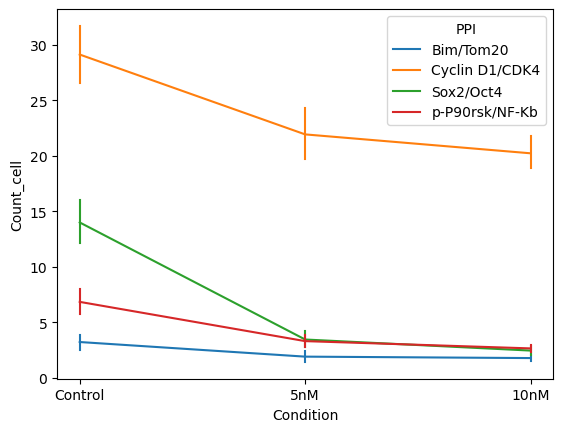

In [15]:
# Plot
sns.lineplot(
    data=df_all[~df_all.Condition.isin([ '25nM', '100nM'])], x="Condition", y="Count_cell", hue="PPI", err_style="bars",
)

In [16]:
# # Describe statistics
# df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel('data.xlsx')

In [18]:
df_subset = df_all[df_all.PPI == 'Cyclin D1/CDK4']

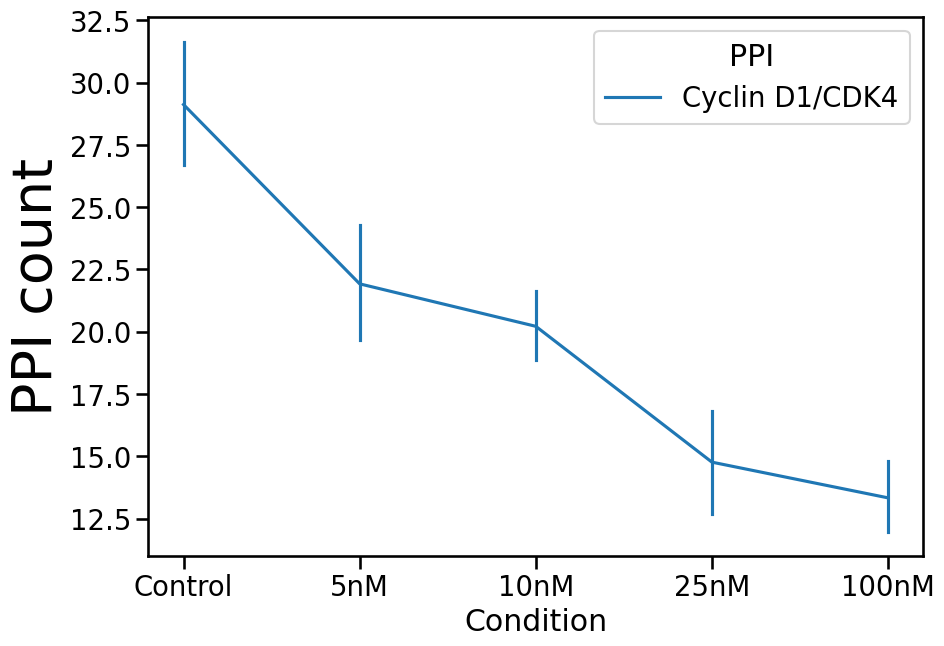

In [19]:
# Plot
with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(10,7))
    sns.lineplot(
        data=df_subset, x="Condition", y="Count_cell", hue="PPI", err_style="bars", ax=ax
    )
    ax.set_ylabel('PPI count', fontsize=40)


## Bar plot quantification

In [18]:
from statannotations.Annotator import Annotator

In [19]:
df_all

,Condition,FOV,Id,PPI,Count_cell,Count_nuclei,Count_cyto
0,100nM,C,2,Bim/Tom20,2.0,0,2.0
2,100nM,C,4,Bim/Tom20,0.0,0,0.0
3,100nM,C,5,Bim/Tom20,2.0,0,2.0
4,100nM,C,6,Bim/Tom20,3.0,0,3.0
5,100nM,C,8,Bim/Tom20,3.0,0,3.0
...,...,...,...,...,...,...,...
3041,Control,B,104,p-P90rsk/NF-Kb,4.0,0,4.0
3042,Control,B,105,p-P90rsk/NF-Kb,11.0,0,11.0
3043,Control,B,106,p-P90rsk/NF-Kb,4.0,0,4.0
3044,Control,B,107,p-P90rsk/NF-Kb,2.0,0,2.0


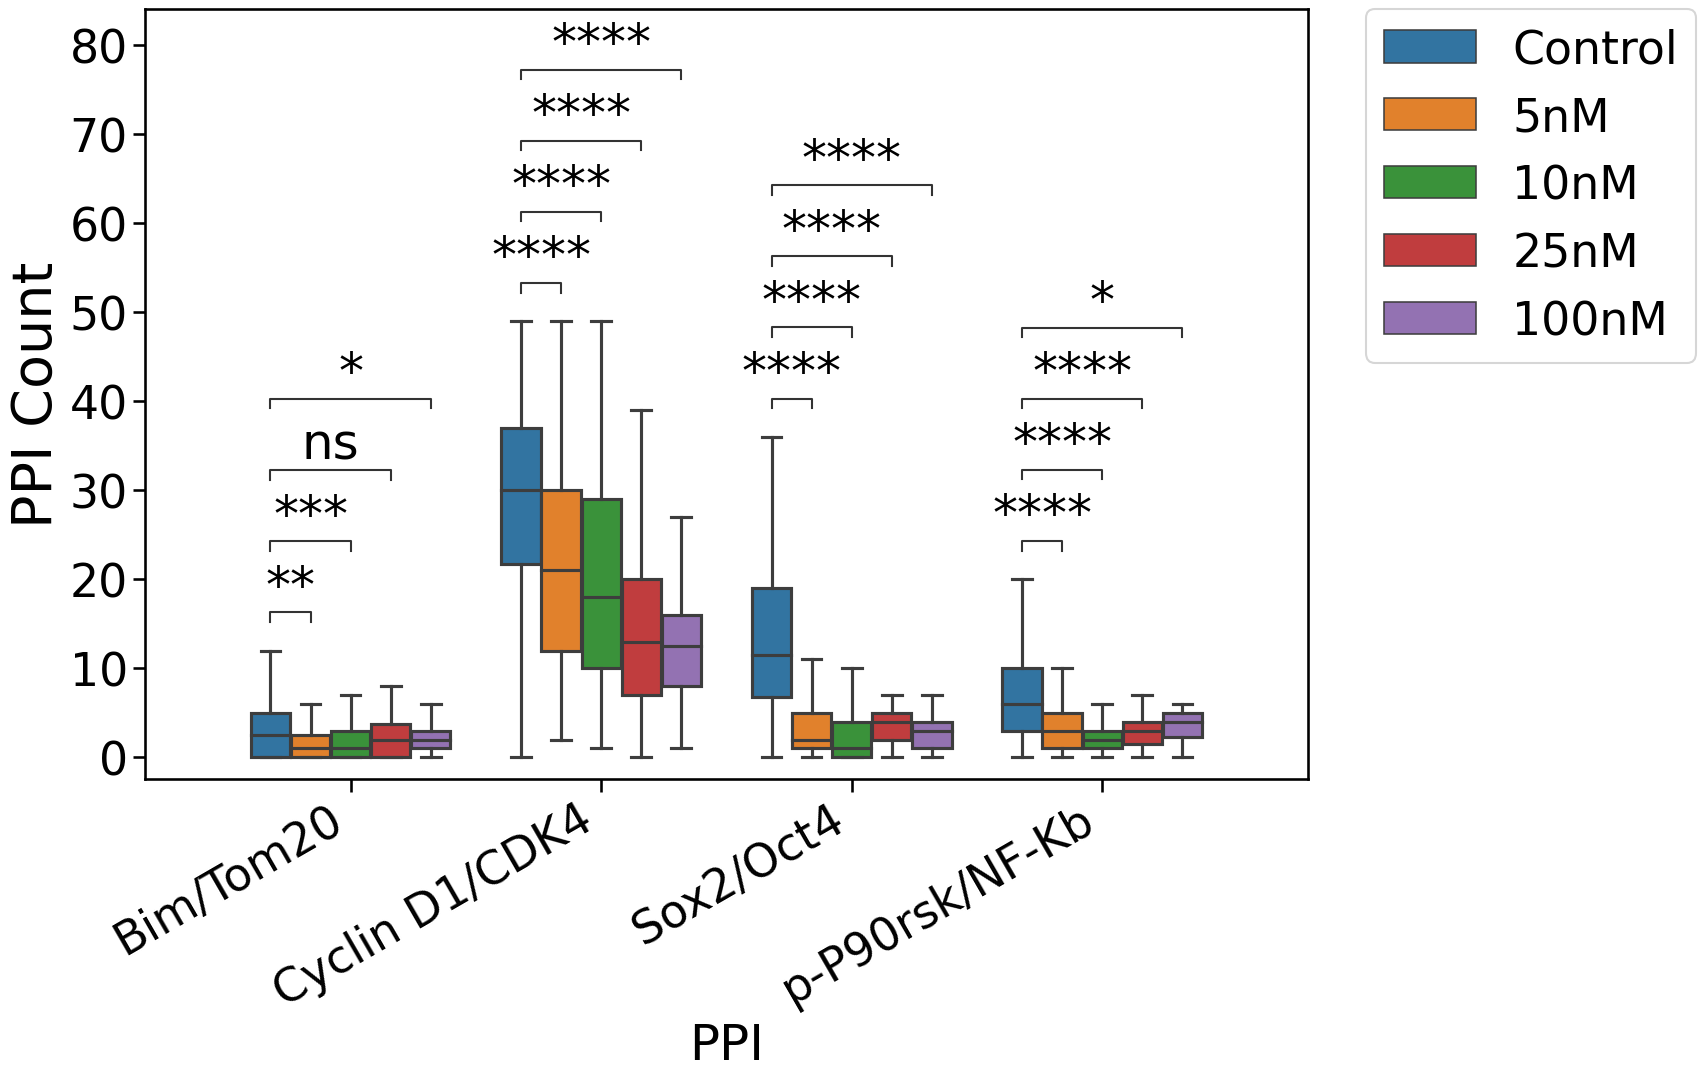

In [23]:
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

pairs = [((e, 'Control'), (e, '5nM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Control'), (e, '10nM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Control'), (e, '25nM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Control'), (e, '100nM')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI Count', fontsize=40)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)